In [2]:
from fastapi import FastAPI
from typing import List
from pydantic import BaseModel

app = FastAPI()

# Creating a class for the attributes input to the ML model.
class ArrayCanvas(BaseModel):
	Ph : float
	Hardness :float
	Solids : float
	Chloramines : float
	Sulfate : float
	Conductivity : float
	Organic_carbon : float
	Trihalomethanes : float
	Turbidity : float

In [2]:
def predict_cnn(data: ArrayCanvas):
    received_array = data['data']
    return received_array

In [4]:
predict_cnn({'data':[1.2124, 2313]})

[1.2124, 2313]

In [3]:
import pandas as pd

In [4]:
img_resize_lanczos = pd.read_pickle('./img_resize.pkl')

In [5]:
# load model
import torch
import torch.nn as nn
import torch.nn.functional as f
import numpy as np

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.l1 = nn.Linear(7*7*32, 1024)
        self.l2 = nn.Linear(1024, 1024)
        self.l3 = nn.Linear(1024, 10)
        self.act = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):                       
        # 入力画像Shape: [batch, 1, 28, 28]
        h = self.pool(self.act(self.conv1(x)))  # [batch, 16, 14, 14]
        h = self.pool(self.act(self.conv2(h)))  # [batch, 32, 7, 7]
        h = h.view(h.size()[0], -1) # 配列サイズを変更
        h = self.act(self.l1(h))
        h = self.act(self.l2(h))
        h = self.l3(h)
        return h
model = CNN()
model.load_state_dict(torch.load('../frontend/model/cnn.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [25]:
ar_resize = np.array(img_resize_lanczos)
ar_resize = ar_resize - ar_resize.min()
ar_resize = ar_resize/ar_resize.max()

In [26]:
lst_data = ar_resize.tolist()

In [34]:
def predict_cnn(lst_data):
    ar_data = np.array(lst_data)
    # newaxis
    ar_data = ar_data[np.newaxis, np.newaxis, :, :]
    # numpy
    ts = torch.from_numpy(ar_data.astype('float32'))
    # model
    output = model(ts)[0]
    ar_output = pd.Series(output.detach().numpy())
    ar_softmax_output = np.exp(ar_output)/np.sum(np.exp(ar_output))
    dict_output = ar_softmax_output.to_dict()
    return dict_output

In [33]:
predict_cnn(data)

{0: 5.825607877341099e-05,
 1: 0.0007851560949347913,
 2: 0.0240333192050457,
 3: 0.018507152795791626,
 4: 0.00010102800297318026,
 5: 7.31652180547826e-05,
 6: 3.090463451371761e-06,
 7: 0.942549467086792,
 8: 0.009674769826233387,
 9: 0.004214681684970856}

In [ ]:
ar_resize = ar_resize[np.newaxis, np.newaxis, :, :]
ts_resize = torch.from_numpy(ar_resize.astype('float32'))

# バッチサイズ1なので、1つ目の出力だけ取り出す
output = model(ts_resize)[0]
s_output = pd.Series(output.detach().numpy())
s_softmax_output = np.exp(s_output)/np.sum(np.exp(s_output))

<AxesSubplot: >

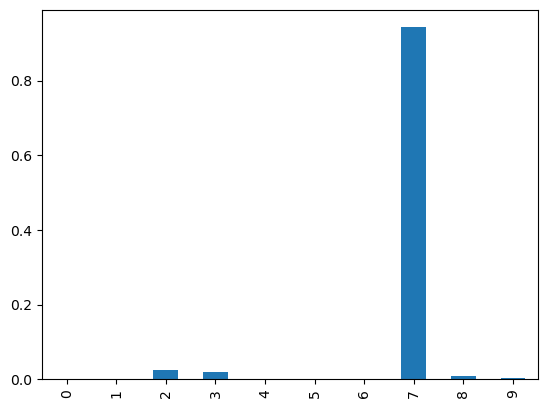

In [14]:
s_softmax_output.plot.bar()

# リクエスト

In [6]:
import json
import requests

In [78]:
header = {'Content-Type': 'application/json'}
url3 = "http://localhost:8000/predict_cnn"
#url= "http://backend_aliases:8000/prediction"
# url3 = "http://backend.docker:8000/predict_cnn"

# payload=json.dumps(result)

In [8]:
data = json.dumps(lst_data)

NameError: name 'lst_data' is not defined

In [98]:
data = pd.read_pickle('../frontend/data.pkl')

In [99]:
lst_data = ar_resize.tolist()
# data = json.dumps(lst_data)
response = requests.request("POST", url3, headers=header, data=data)
print(response)
d = json.loads(response.content)
d

<Response [200]>


{'0': 0.13560277223587036,
 '1': 0.10923530906438828,
 '2': 0.14221177995204926,
 '3': 0.10495632141828537,
 '4': 0.035899244248867035,
 '5': 0.1136384829878807,
 '6': 0.06832670420408249,
 '7': 0.060915008187294006,
 '8': 0.11713291704654694,
 '9': 0.11208144575357437}